In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [13]:
df = pd.read_csv('dataset/data.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [12]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']) #changed the date time format

In [14]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [16]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [17]:
df.Country.value_counts(normalize=True) 

United Kingdom          0.914320
Germany                 0.017521
France                  0.015790
EIRE                    0.015124
Spain                   0.004674
Netherlands             0.004375
Belgium                 0.003818
Switzerland             0.003694
Portugal                0.002803
Australia               0.002323
Norway                  0.002004
Italy                   0.001482
Channel Islands         0.001399
Finland                 0.001283
Cyprus                  0.001148
Sweden                  0.000853
Unspecified             0.000823
Austria                 0.000740
Denmark                 0.000718
Japan                   0.000661
Poland                  0.000629
Israel                  0.000548
USA                     0.000537
Hong Kong               0.000531
Singapore               0.000423
Iceland                 0.000336
Canada                  0.000279
Greece                  0.000269
Malta                   0.000234
United Arab Emirates    0.000125
European C

In [18]:
# Since more than 90% of the customers, talking only UK customers for the analysis
df = df[df.Country == 'United Kingdom']

In [36]:
# Removing the negative values from Quantity and UnitPrice
df = df[df.Quantity > 0]
df = df[df.UnitPrice > 0]

In [35]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceYearMonth'] = df['InvoiceDate'].map(lambda date: 100*date.year + date.month)
df['Date'] = df['InvoiceDate'].dt.strftime('%Y-%m')

C:\Users\USER\AppData\Local\Temp\ipykernel_8832\1983518754.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [37]:
#Removing the Null values from the data.

df = df[pd.notnull(df['CustomerID'])]

Exploratory Data Analysis

In [38]:
#Aggregating the Orders by Month

df_agg= df.groupby("Date").Quantity.sum()
df_agg.head()

Date
2010-12    267767
2011-01    278251
2011-02    213375
2011-03    276304
2011-04    260448
Name: Quantity, dtype: int64

In [39]:
#Calculating Revenue
#Revenue = Order Count * Average Revenue per Order

df['Revenue'] = df['Quantity']*df['UnitPrice']

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354321 entries, 0 to 541893
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   InvoiceNo         354321 non-null  object        
 1   StockCode         354321 non-null  object        
 2   Description       354321 non-null  object        
 3   Quantity          354321 non-null  int64         
 4   InvoiceDate       354321 non-null  datetime64[ns]
 5   UnitPrice         354321 non-null  float64       
 6   CustomerID        354321 non-null  float64       
 7   Country           354321 non-null  object        
 8   InvoiceYearMonth  354321 non-null  int64         
 9   Date              354321 non-null  object        
 10  Revenue           354321 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(5)
memory usage: 32.4+ MB


RFM Analysis

In [44]:
# The last invoice date is 2011–12–09
NOW = dt.date(2011,12,9) 


In [45]:
#Recency

df_recency = df.groupby(['CustomerID'],as_index=False)['Date'].max()
df_recency.columns = ['CustomerID','Last_Purchase_Date']

df_recency['Recency'] = df_recency.Last_Purchase_Date.apply(lambda x:(NOW - x).days)
df_recency.drop(columns=['Last_Purchase_Date'],inplace=True)
df_recency.head()

,CustomerID,Recency
0,12346.0,325
1,12747.0,2
2,12748.0,0
3,12749.0,3
4,12820.0,3


In [46]:
#Frequency - Monetarty

FM_Table = df.groupby('CustomerID').agg({'InvoiceNo'   : lambda x:len(x),
                                         'Revenue'  : lambda x:x.sum()})
FM_Table.rename(columns = {'InvoiceNo' :'Frequency',
                           'Revenue':'Monetary'},inplace= True)
FM_Table.head()

,Frequency,Monetary
CustomerID,,
12346.0,1,77183.60
12747.0,103,4196.01
12748.0,4595,33719.73
12749.0,199,4090.88
12820.0,59,942.34


In [47]:
RFM_Table = df_recency.merge(FM_Table,left_on='CustomerID',right_on='CustomerID')
RFM_Table.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12747.0,2,103,4196.01
2,12748.0,0,4595,33719.73
3,12749.0,3,199,4090.88
4,12820.0,3,59,942.34


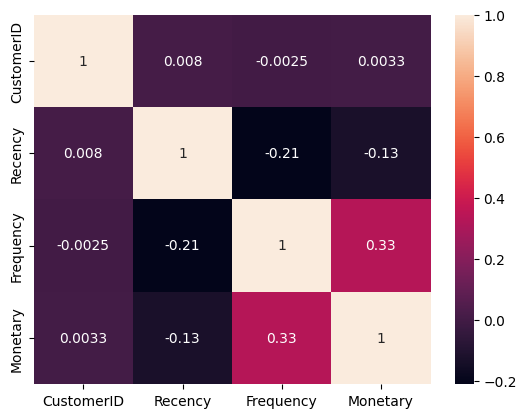

In [48]:
#Heatmap check
sns.heatmap(RFM_Table.corr(), annot=True);

RFM Quantiles

In [49]:
quantiles = RFM_Table.quantile(q=[0.25,0.50,0.75])
quantiles = quantiles.to_dict()

In [66]:
segmented_rfm = RFM_Table.copy()

In [ ]:
# assigning a score
# from 1 to 4 to each Recency, Frequency and Monetary respectively. 

In [50]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [67]:
segmented_rfm['R_quartile'] = segmented_rfm['Recency'].apply(RScore, args=('Recency',quantiles))
segmented_rfm['F_quartile'] = segmented_rfm['Frequency'].apply(FMScore, args=('Frequency',quantiles))
segmented_rfm['M_quartile'] = segmented_rfm['Monetary'].apply(FMScore, args=('Monetary',quantiles))
segmented_rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_quartile,F_quartile,M_quartile,RFM_Segment
0,12346.0,325,1,77183.60,4,4,1,441
1,12747.0,2,103,4196.01,1,1,1,111
2,12748.0,0,4595,33719.73,1,1,1,111
3,12749.0,3,199,4090.88,1,1,1,111
4,12820.0,3,59,942.34,1,2,2,122


In [68]:
segmented_rfm['RFM_Segment'] = segmented_rfm.R_quartile.map(str)+segmented_rfm.F_quartile.map(str)+segmented_rfm.M_quartile.map(str)

In [69]:
segmented_rfm['RFM_Score'] = segmented_rfm[['R_quartile','F_quartile','M_quartile']].sum(axis=1)

In [70]:
segmented_rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_quartile,F_quartile,M_quartile,RFM_Segment,RFM_Score
0,12346.0,325,1,77183.60,4,4,1,441,9
1,12747.0,2,103,4196.01,1,1,1,111,3
2,12748.0,0,4595,33719.73,1,1,1,111,3
3,12749.0,3,199,4090.88,1,1,1,111,3
4,12820.0,3,59,942.34,1,2,2,122,5


In [71]:
print("Best Customers: ",len(segmented_rfm[segmented_rfm['RFM_Segment']=='111']))
print('Loyal Customers: ',len(segmented_rfm[segmented_rfm['F_quartile']==1]))
print("Big Spenders: ",len(segmented_rfm[segmented_rfm['M_quartile']==1]))
print('Almost Lost: ', len(segmented_rfm[segmented_rfm['RFM_Segment']=='134']))
print('Lost Customers: ',len(segmented_rfm[segmented_rfm['RFM_Segment']=='344']))
print('Lost Cheap Customers: ',len(segmented_rfm[segmented_rfm['RFM_Segment']=='444']))

Best Customers:  409
Loyal Customers:  980
Big Spenders:  980
Almost Lost:  21
Lost Customers:  168
Lost Cheap Customers:  343


In [72]:
# Setting up the label for each client and adding the column "Label" to the dataframe

label = [0] * len(segmented_rfm)

for i in range(0,len(segmented_rfm)):

    if segmented_rfm['RFM_Segment'][i] == '111':
        label[i] = "Best Customers"
        
    elif segmented_rfm['RFM_Segment'][i] == '134' :
        label[i] = "Almost Lost"
        
    elif segmented_rfm['RFM_Segment'][i] == '344':
        label[i] = "Lost Customers"
    
    elif segmented_rfm['RFM_Segment'][i] == '444':
        label[i] = "Lost Cheap Customers"

    elif segmented_rfm['F_quartile'][i] == 1:
        label[i] = "Loyal Customers"  
    
    elif segmented_rfm['M_quartile'][i] == 1:
        label[i] = "Big Spenders"   
        
    else:
        label[i] = "Others"

In [73]:
# Adding the 'Label' column to our dataframe

segmented_rfm['Label'] = label

In [74]:
segmented_rfm['Label'].value_counts()

Others                  2135
Loyal Customers          571
Best Customers           409
Lost Cheap Customers     343
Big Spenders             273
Lost Customers           168
Almost Lost               21
Name: Label, dtype: int64

C:\Users\USER\AppData\Local\Temp\ipykernel_8832\29814441.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sq1, x="Label", y="CustomerID", palette = "Greens_d");


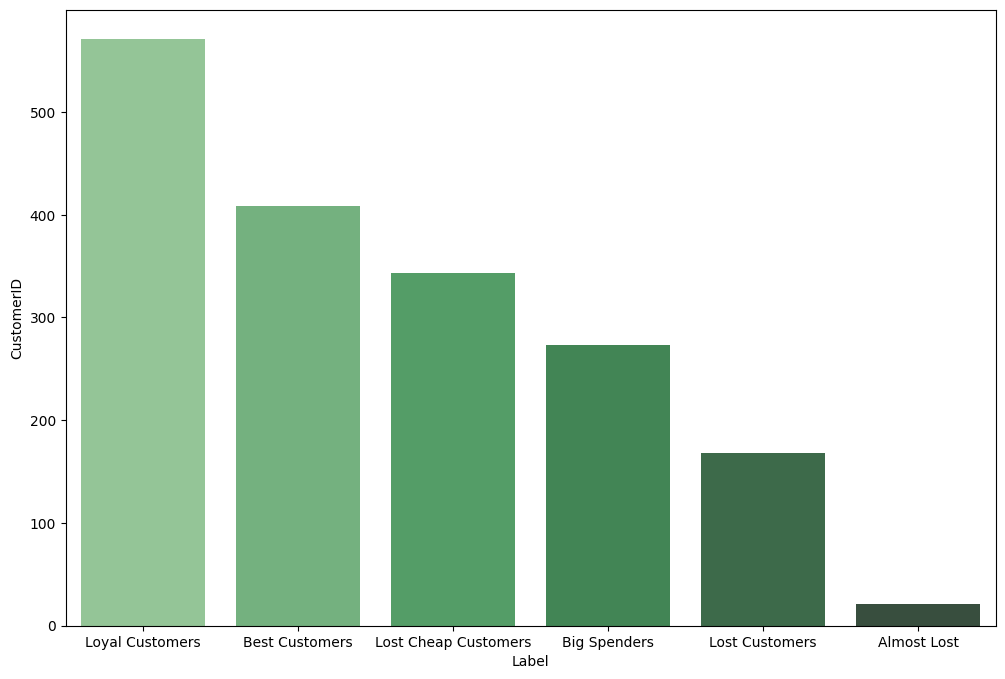

In [75]:
import seaborn as sns
sq1=segmented_rfm.groupby('Label')['CustomerID'].nunique().sort_values(ascending=False).reset_index()
plt.figure(figsize=(12,8))
sq1.drop([0],inplace=True)
sns.barplot(data=sq1, x="Label", y="CustomerID", palette = "Greens_d");

C:\Users\USER\AppData\Local\Temp\ipykernel_8832\3758633479.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(RFM_Table['Recency'])


<Axes: xlabel='Recency', ylabel='Density'>

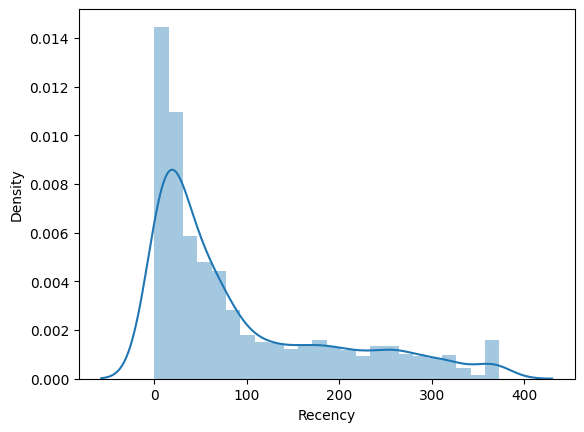

In [56]:
#Analyze distribution

sns.distplot(RFM_Table['Recency'])

C:\Users\USER\AppData\Local\Temp\ipykernel_8832\4256306844.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(RFM_Table['Frequency'])


<Axes: xlabel='Frequency', ylabel='Density'>

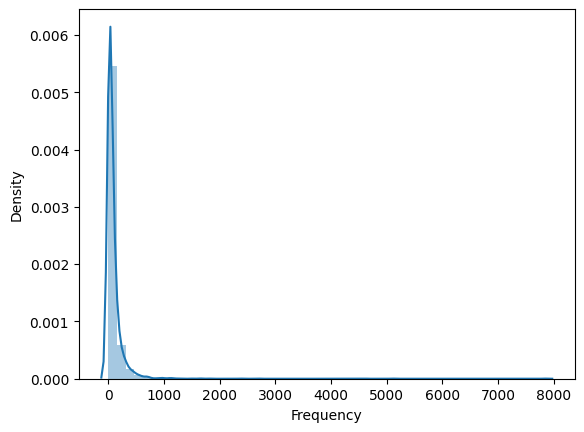

In [58]:
sns.distplot(RFM_Table['Frequency'])

C:\Users\USER\AppData\Local\Temp\ipykernel_8832\1282112945.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(RFM_Table['Monetary'])


<Axes: xlabel='Monetary', ylabel='Density'>

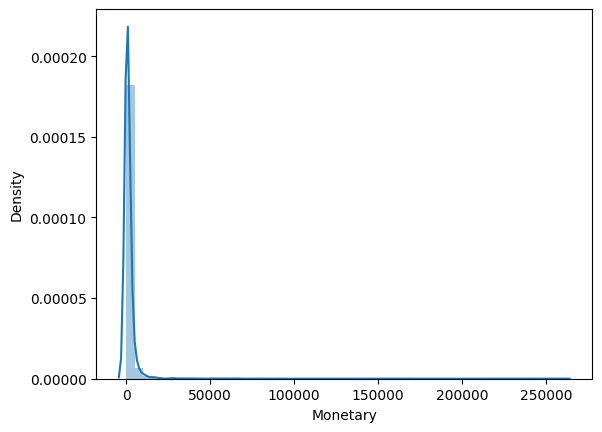

In [60]:
sns.distplot(RFM_Table['Monetary'])

In [ ]:
# From the above dist plot it is observed that the data is highly skewed
# Which reduces the result of K-Means clustering
# In order to reduce the skewness, Log Transformation should be performed

In [80]:
RFM_Table = df_recency.merge(FM_Table,left_on='CustomerID',right_on='CustomerID')
RFM_Table.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12747.0,2,103,4196.01
2,12748.0,0,4595,33719.73
3,12749.0,3,199,4090.88
4,12820.0,3,59,942.34


In [85]:
RFM_Table_New = RFM_Table.drop('CustomerID', axis=1)

In [86]:
RFM_Table_New.head()

,Recency,Frequency,Monetary
0,325,1,77183.60
1,2,103,4196.01
2,0,4595,33719.73
3,3,199,4090.88
4,3,59,942.34


In [87]:
df_rfm_log = RFM_Table_New.copy()
df_rfm_log.head()

,Recency,Frequency,Monetary
0,325,1,77183.60
1,2,103,4196.01
2,0,4595,33719.73
3,3,199,4090.88
4,3,59,942.34


In [89]:
df_rfm_log = RFM_Table_New.copy()
df_rfm_log.head()

,Recency,Frequency,Monetary
0,325,1,77183.60
1,2,103,4196.01
2,0,4595,33719.73
3,3,199,4090.88
4,3,59,942.34


In [90]:
# Taking logarithm 
df_rfm_log = np.log(df_rfm_log+1)

In [94]:
scaler = StandardScaler()

scaler.fit(df_rfm_log)

RFM_Table_New_scaled = scaler.transform(df_rfm_log)

In [97]:
RFM_Table_New_scaled = pd.DataFrame(RFM_Table_New_scaled, columns=RFM_Table_New.columns)
RFM_Table_New_scaled.head()

,Recency,Frequency,Monetary
0,1.438428,-2.403387,3.785914
1,-1.953555,0.732578,1.444280
2,-2.748403,3.739419,3.119983
3,-1.745416,1.251577,1.423880
4,-1.745416,0.296025,0.243880


C:\Users\USER\AppData\Local\Temp\ipykernel_8832\1039827238.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(RFM_Table_New_scaled['Recency'])


<Axes: xlabel='Recency', ylabel='Density'>

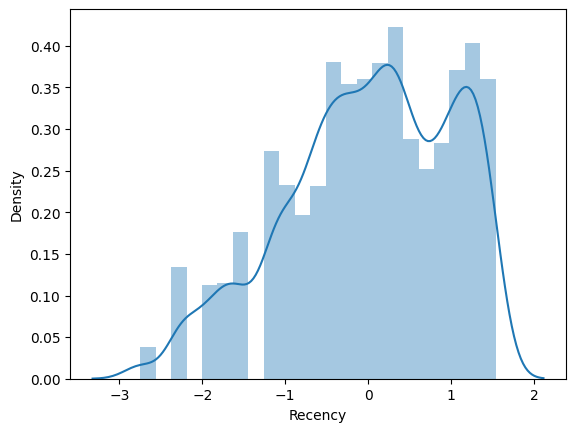

In [98]:

sns.distplot(RFM_Table_New_scaled['Recency'])

C:\Users\USER\AppData\Local\Temp\ipykernel_8832\1164892232.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(RFM_Table_New_scaled['Frequency'])


<Axes: xlabel='Frequency', ylabel='Density'>

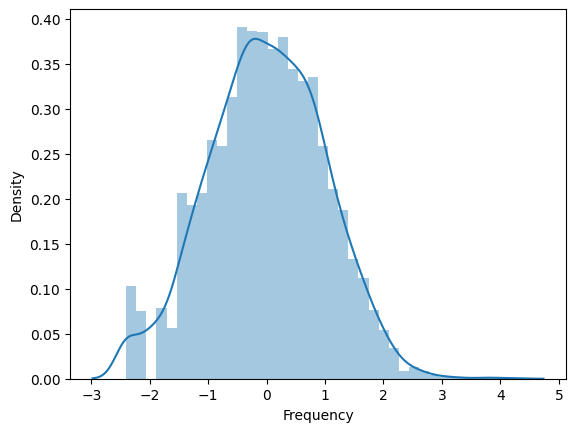

In [99]:
sns.distplot(RFM_Table_New_scaled['Frequency'])

C:\Users\USER\AppData\Local\Temp\ipykernel_8832\2458755364.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(RFM_Table_New_scaled['Monetary'])


<Axes: xlabel='Monetary', ylabel='Density'>

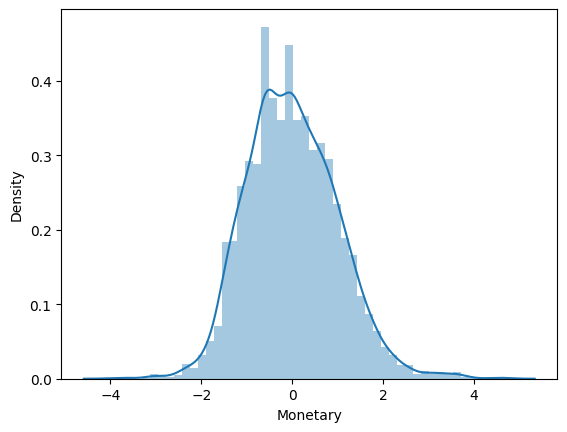

In [100]:
sns.distplot(RFM_Table_New_scaled['Monetary'])

In [101]:
X = np.asarray(RFM_Table_New_scaled)

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `

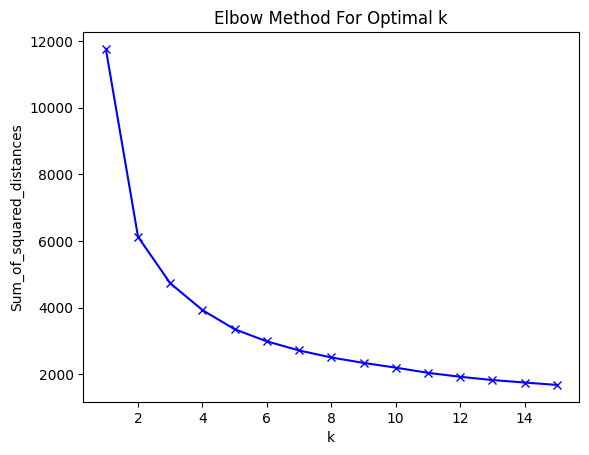

In [102]:
# Applying Elbow method to determine optimal number of clusters
Sum_of_squared_distances = []
K = range(1,16)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [106]:
def kmeans(normalised_df_rfm, clusters_number, original_df_rfm):
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_rfm)

    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


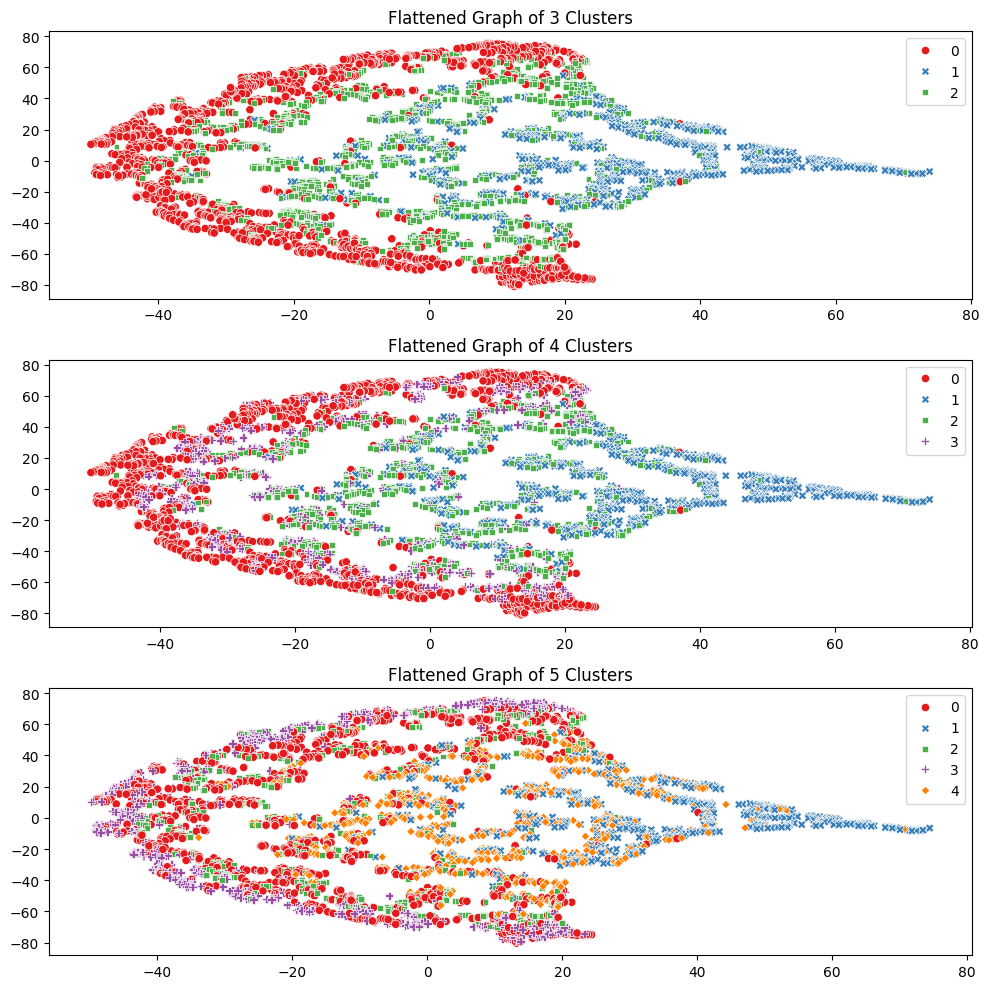

In [107]:
plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
df_rfm_k3 = kmeans(RFM_Table_New_scaled, 3, RFM_Table)

plt.subplot(3, 1, 2)
df_rfm_k4 = kmeans(RFM_Table_New_scaled, 4, RFM_Table)

plt.subplot(3, 1, 3)
df_rfm_k5 = kmeans(RFM_Table_New_scaled, 5, RFM_Table)

plt.tight_layout()


Evaluation of K- Means
- Davies Boulding Score

In [110]:
from sklearn.metrics import davies_bouldin_score

In [111]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3)

In [112]:
print(davies_bouldin_score(X, kmeans.labels_))

1.097730003289982


In [113]:
# K - 4
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=4)

In [114]:
print(davies_bouldin_score(X, kmeans.labels_))

1.0631215924157293


In [115]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=5)

In [116]:
print(davies_bouldin_score(X, kmeans.labels_))

1.0828072764478234


K-Means 4 clusters has lowest davies bouldin score than other cluster. Therefore the optimum cluster is 4.

In [117]:
df_rfm_k4.head()

,CustomerID,Recency,Frequency,Monetary,Cluster
0,12346.0,325,1,77183.60,2
1,12747.0,2,103,4196.01,1
2,12748.0,0,4595,33719.73,1
3,12749.0,3,199,4090.88,1
4,12820.0,3,59,942.34,3


In [118]:
df_rfm_k4.Cluster.value_counts()

0    1209
2    1159
1     778
3     774
Name: Cluster, dtype: int64

C:\Users\USER\AppData\Local\Temp\ipykernel_8832\3699283735.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sq1, x="Cluster", y="CustomerID", palette = "Greens_d");


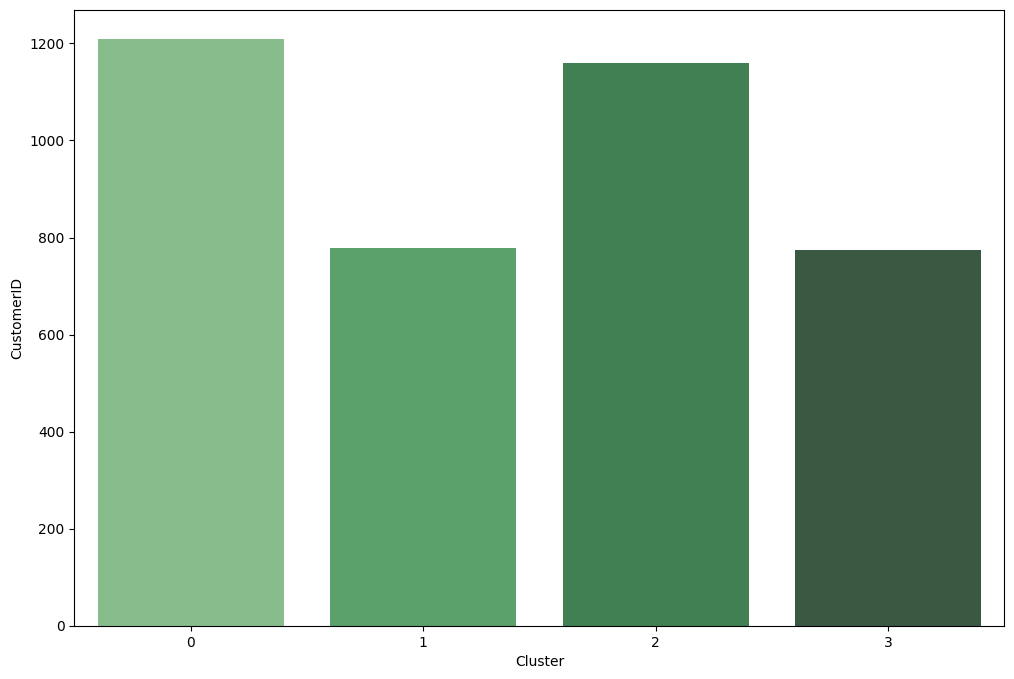

In [119]:
import seaborn as sns
sq1=df_rfm_k4.groupby('Cluster')['CustomerID'].nunique().sort_values(ascending=False).reset_index()
plt.figure(figsize=(12,8))
sns.barplot(data=sq1, x="Cluster", y="CustomerID", palette = "Greens_d");